# Insurace Risk Analysis Project

In this project, I have used 2017 data to build a model for finding out probability of customers to ask for a claim in future (2018), along with severity of their claim in USD amount and then create Risk profile based on their probability of asking for a claim.

A glossary for the datasets is provided below:

* pol_number: policy number for the insurance policy
* pol_eff_dt auto insurance policy effective date
* gender gender of driver: F, M
* agecat driver's age category: 1 (youngest), 2, 3, 4, 5, 6
* date_of_birth driver's date of birth
* credit_score driver’s credit score(integer): 1-100, 1=poor, 100=excellent
* area driver's area of residence: A, B, C, D, E, F
* traffic_index traffic index of driver’s area of residence(integer): 100=country average, >100 means worse traffic conditions than average
* veh_age age of vehicle(categorical): 1 (youngest), 2, 3, 4
* veh_body vehicle body, coded as:
                                    BUS
                                    CONVT = convertible
                                    COUPE
                                    HBACK = hatchback
                                    HDTOP = hardtop
                                    MCARA = motorized caravan
                                    MIBUS = minibus
                                    PANVN = panel van
                                    RDSTR = roadster
                                    SEDAN
                                    STNWG = station wagon
                                    TRUCK
                                    UTE = utility
* veh_value vehicle value, in dollar 10,000
* smonths_insured number of months vehicle insurance is bought(integer)
* claim_office office location of claim handling agent: A, B, C, D
* numclaims number of claims(integer): 0 if no claim
* claimcst0 claim amount: 0 if no claim
* annual_premium total charged premium

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error, r2_score, classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import seaborn as sns
import seaborn as sns
import math


df_2017=pd.read_csv("Data/policies_2017.csv",parse_dates=True)
df_2018=pd.read_csv("Data/potential_customers_2018.csv",parse_dates=True)

In [2]:
df_2017.head()

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium
0,64080188,7/10/2017,M,2.0,1/4/1989,631.0,B,140.9,4,TRUCK,0.924,NaN,0,0.000000,716.53
1,18917133,7/31/2017,M,2.0,6/21/1985,531.0,C,136.5,3,HBACK,1.430,B,1,583.010876,716.53
2,82742606,2/1/2017,M,6.0,7/25/1942,838.0,D,88.8,3,SEDAN,1.100,D,1,159.375757,716.53
3,43601997,10/17/2017,M,5.0,6/8/1959,835.0,E,NaN,2,SEDAN,2.090,NaN,0,0.000000,716.53
4,58746861,4/13/2017,F,4.0,5/16/1967,748.0,C,123.0,3,HBACK,0.803,C,1,143.555642,716.53


# EDA

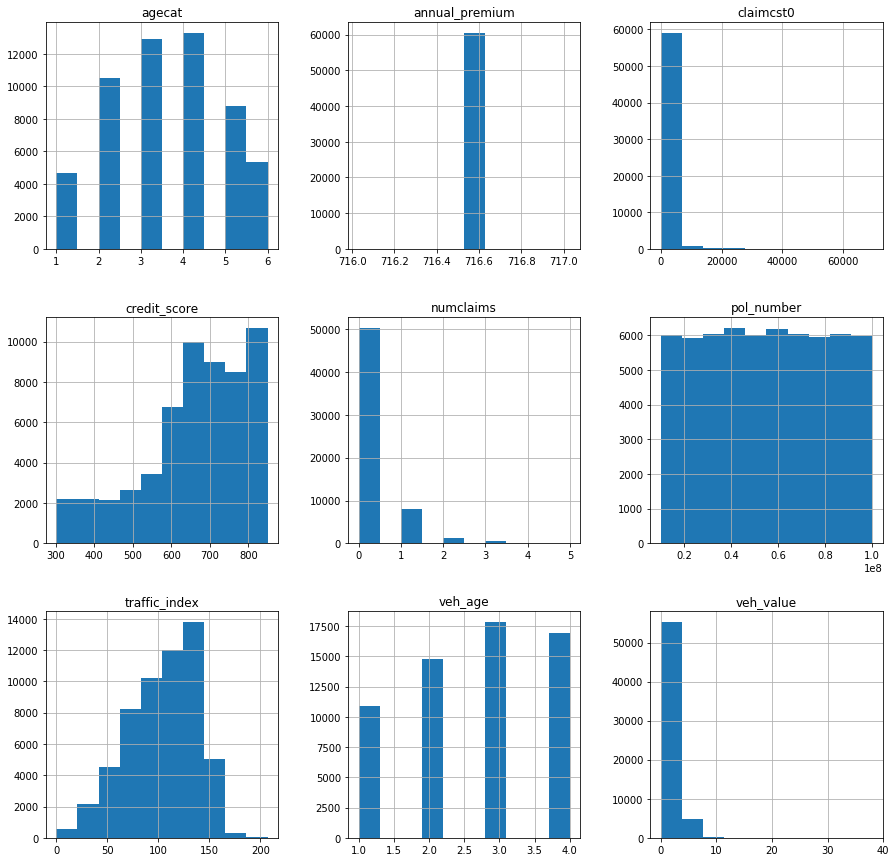

In [3]:
pd.DataFrame.hist(df_2017, figsize = [15,15]);


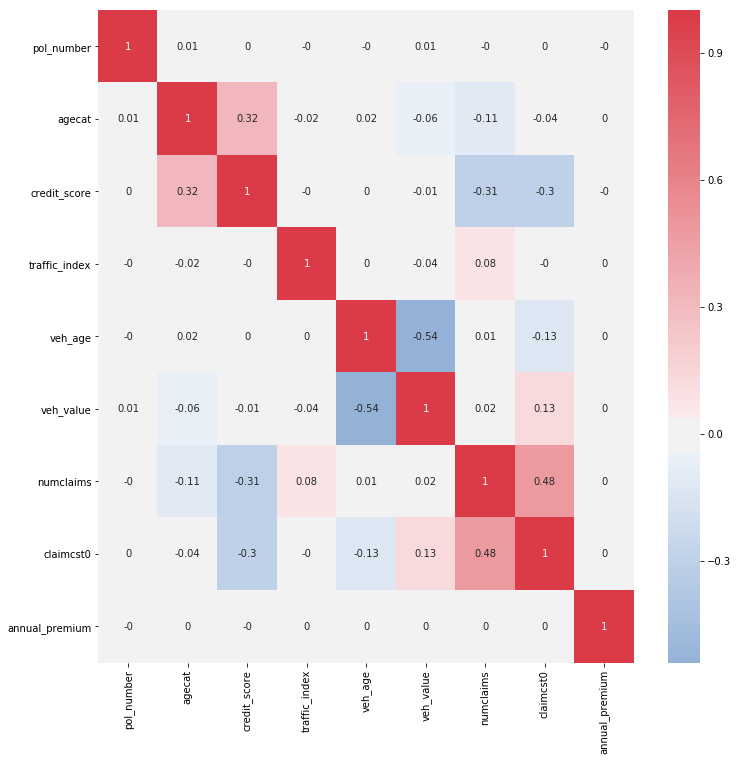

In [4]:
# Plotting Coorelation Matrix to see if there is any correlation
df_num = df_2017.select_dtypes(include = ['float64', 'int64'])
cor_matrix = df_num.corr().round(2)
fig = plt.figure(figsize=(12,12));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

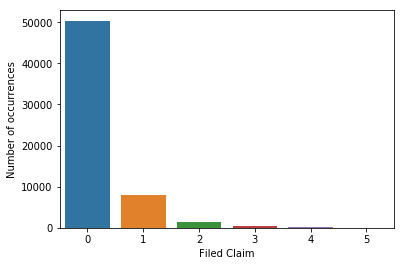

In [5]:
sns.countplot(df_2017.numclaims);
plt.xlabel('Filed Claim');
plt.ylabel('Number of occurrences');
plt.show()

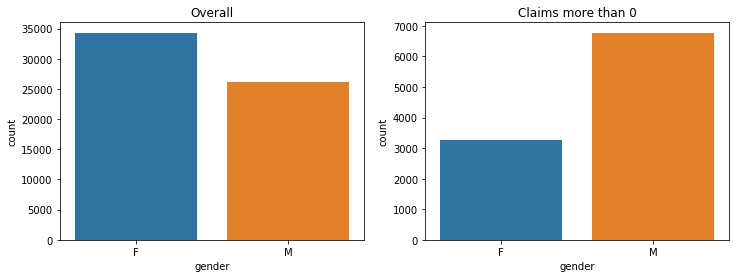

In [6]:
#Sort by sex
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,4)
g = sns.countplot(x='gender',data=df_2017.sort_values('gender'), ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='gender',data=df_2017[df_2017['numclaims']>0].sort_values('gender'), ax=ax2)
title = g.set_title('Claims more than 0')

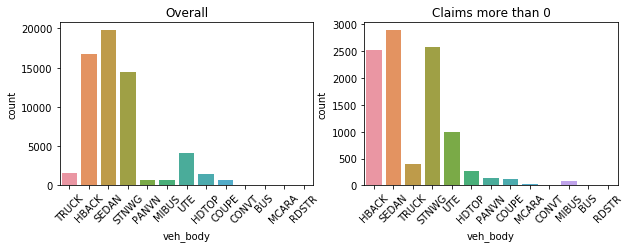

In [7]:
#Visualize Vehicle Body Type
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='veh_body',data=df_2017, ax=ax1)
label = g.set_xticklabels(g.get_xticklabels(), rotation=45)
title = g.set_title('Overall')
g = sns.countplot(x='veh_body',data=df_2017[df_2017['numclaims']>0], ax=ax2)
label = g.set_xticklabels(g.get_xticklabels(), rotation=45)
title = g.set_title('Claims more than 0')

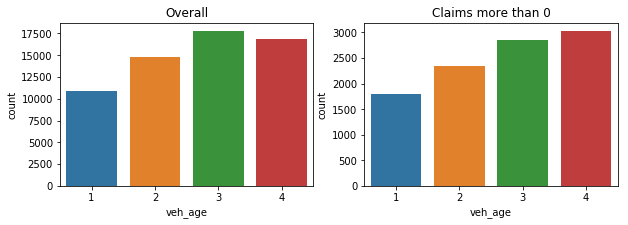

In [8]:
#Visualize Vehicle Age
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='veh_age',data=df_2017, ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='veh_age',data=df_2017[df_2017['numclaims']>0], ax=ax2)
title = g.set_title('Claims more than 0')

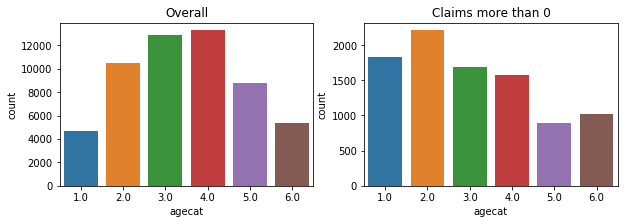

In [9]:
#Visualize Driver Age
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='agecat',data=df_2017, ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='agecat',data=df_2017[df_2017['numclaims']>0], ax=ax2)
title = g.set_title('Claims more than 0')

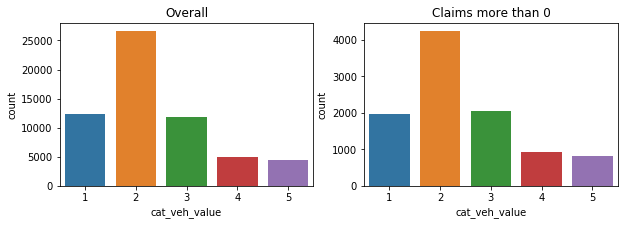

In [10]:
#Make Vehicle Value categorical
df_2017['cat_veh_value'] = df_2017['veh_value'].apply(lambda x:1 if x<=1 else 2 if x<=2 else 3 if x<=3 else 4 if x<=4 else 5)
#Visualize Vehicle Value
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10,3)
g = sns.countplot(x='cat_veh_value',data=df_2017, ax=ax1)
title = g.set_title('Overall')
g = sns.countplot(x='cat_veh_value',data=df_2017[df_2017['numclaims']>0], ax=ax2)
title = g.set_title('Claims more than 0')

# Data Prep and Cleaning

In [11]:
df_2017.isnull().sum()

pol_number            0
pol_eff_dt            0
gender                0
agecat             4831
date_of_birth         0
credit_score       2801
area                  0
traffic_index      3503
veh_age               0
veh_body              0
veh_value             0
claim_office      50362
numclaims             0
claimcst0             0
annual_premium        0
cat_veh_value         0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a187ad390>]],
      dtype=object)

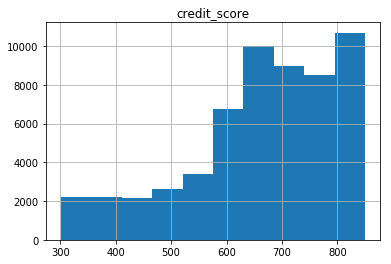

In [12]:
df_2017.hist(column='credit_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a17ffcdd8>]],
      dtype=object)

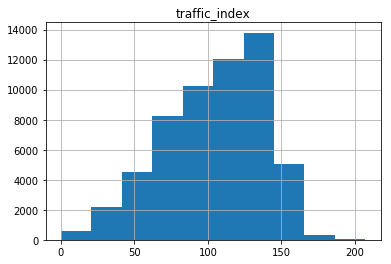

In [13]:
df_2017.hist(column='traffic_index')

In [14]:
#Function to impute missing values in 'agecat', 'credit_score' and 'traffic_index'
def missing_value(data):
    
    """ Function takes in raw data and returns cleaned data, in imputing age, bins have been crosschecked with the 
    excel file. Class labels 6 = 1900-1949, 5= 1950-159, 4 =1960-1969, 3=1970-1979, 2= 1980-1989, 1=1990-1999"""
    
    data["date_of_birth"] = pd.to_datetime(data['date_of_birth'])
    data["DOB_year"]=data.date_of_birth.dt.year
    labels=[6,5,4,3,2,1]
    data["agecat_new"] = pd.cut(df_2017.DOB_year, bins = [1900,1949,1959,1969,1979,1989,1999],labels=labels, include_lowest=True)
    data["credit_score"] = data.groupby('agecat_new')['credit_score'].apply(lambda x: x.fillna(x.mean()))
    data['veh_value'] = (data['veh_value']+1).apply(np.log)
    data.traffic_index.fillna(data.traffic_index.mean(), inplace=True)
    data.drop(["agecat"],axis=1,inplace=True)
    return(data)

In [15]:
clean_data_2017=missing_value(df_2017)
clean_data_2018=missing_value(df_2018)

In [16]:
clean_data_2017.isnull().sum()

pol_number            0
pol_eff_dt            0
gender                0
date_of_birth         0
credit_score          0
area                  0
traffic_index         0
veh_age               0
veh_body              0
veh_value             0
claim_office      50362
numclaims             0
claimcst0             0
annual_premium        0
cat_veh_value         0
DOB_year              0
agecat_new            0
dtype: int64

In [17]:
clean_data_2018.isnull().sum()

quote_number     0
gender           0
date_of_birth    0
credit_score     0
area             0
traffic_index    0
veh_age          0
veh_body         0
veh_value        0
DOB_year         0
agecat_new       0
dtype: int64

Comparing the distribution of Credit score and traffic index post imputing. We can observe that it looks pretty much the same.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a227ed940>]],
      dtype=object)

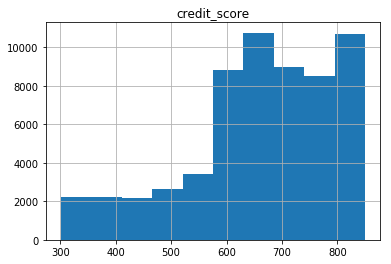

In [18]:
clean_data_2017.hist(column='credit_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a18e18f60>]],
      dtype=object)

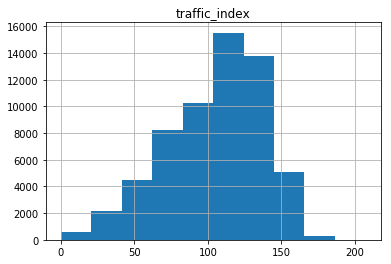

In [19]:
clean_data_2017.hist(column='traffic_index')

In [20]:
# Removing irrelevant columns for building model

data_2017=clean_data_2017.drop(["claim_office","pol_number","pol_eff_dt","cat_veh_value","annual_premium","date_of_birth","DOB_year"],axis=1)
data_2018=clean_data_2018.drop(["quote_number","date_of_birth","DOB_year"],axis=1)
data_2018.head()

,gender,credit_score,area,traffic_index,veh_age,veh_body,veh_value,agecat_new
0,F,750.0,C,124.500000,2,HBACK,0.741937,2
1,M,567.0,F,104.416636,3,STNWG,1.124605,2
2,M,378.0,D,111.400000,3,HDTOP,1.210154,6
3,F,807.0,E,104.416636,4,UTE,1.088225,5
4,M,844.0,C,111.000000,1,HBACK,1.088225,4


### Creating Dummy Variable

In [21]:
# Dummy variable conversion using pd.dummies

data_2017=pd.get_dummies(data=data_2017, columns=['gender', 'area','veh_body'],drop_first=True)
data_2018=pd.get_dummies(data=data_2018, columns=['gender', 'area','veh_body'],drop_first=True)

In [22]:
def claim(x):
    """ Function converts claims above 0 to value 1,in order to creat a 
        class of 1 and 0 for those who claimed and those who did not"""
    if x == 0:
        return 0
    else:
        return 1
    
data_2017["claim"] = data_2017["numclaims"].apply(claim)

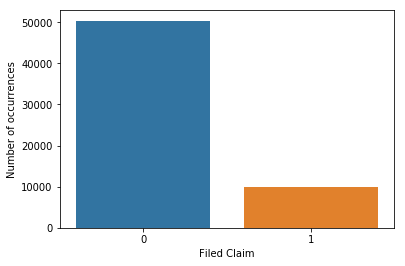

In [23]:
#Distribution of Claim class

sns.countplot(data_2017.claim);
plt.xlabel('Filed Claim');
plt.ylabel('Number of occurrences');
plt.show()

### Since our minority class consist of 16% of the total data, we dont need to resample. We can simply use Stratefied KFold to sample it in our training and test set

In [24]:
#Creating test and train set 


X=data_2017.drop(["numclaims","claimcst0","claim"],axis=1)
y1=data_2017["claimcst0"]
y=data_2017["claim"]
x_test=data_2018

In [25]:
X.isnull().sum()

credit_score      0
traffic_index     0
veh_age           0
veh_value         0
agecat_new        0
gender_M          0
area_B            0
area_C            0
area_D            0
area_E            0
area_F            0
veh_body_CONVT    0
veh_body_COUPE    0
veh_body_HBACK    0
veh_body_HDTOP    0
veh_body_MCARA    0
veh_body_MIBUS    0
veh_body_PANVN    0
veh_body_RDSTR    0
veh_body_SEDAN    0
veh_body_STNWG    0
veh_body_TRUCK    0
veh_body_UTE      0
dtype: int64

In [ ]:
# Grid search
logreg = LogisticRegression(class_weight='balanced')
param = {'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1]}
clf = GridSearchCV(logreg, param, scoring='roc_auc', refit=True, cv=3, n_jobs=8)
clf.fit(X, y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))


1 of kfold 10
roc_auc_score 0.8134510504618763

2 of kfold 10
roc_auc_score 0.8144494449943795

3 of kfold 10
roc_auc_score 0.8123837383797773

4 of kfold 10
roc_auc_score 0.8187914414025595

5 of kfold 10
roc_auc_score 0.8200511650117163

6 of kfold 10
roc_auc_score 0.8103948678191003

7 of kfold 10
roc_auc_score 0.8098543923432245

8 of kfold 10
roc_auc_score 0.8038663992137961

9 of kfold 10
roc_auc_score 0.8094851664228918

10 of kfold 10
roc_auc_score 0.8138151074972066


Text(0.5,0,'False positive rate')

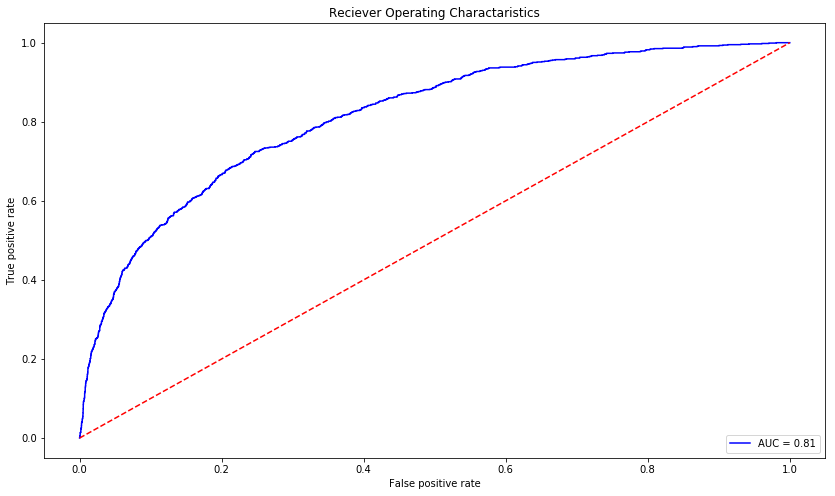

In [26]:

seed = 45
kf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
pred_test_full = 0
cv_score = []
i = 1
for train_index, test_index in kf.split(X, y):
    print('\n{} of kfold {}'.format(i, kf.n_splits))
    xtr, xvl = X.loc[train_index], X.loc[test_index]
    ytr, yvl = y[train_index], y[test_index]

    lr = LogisticRegression(class_weight='balanced', C=0.005)
    lr.fit(xtr, ytr)
    pred_test = lr.predict_proba(xvl)[:, 1]
    score = roc_auc_score(yvl, pred_test)
    print('roc_auc_score', score)
    cv_score.append(score)
    pred_test_full += lr.predict_proba(x_test)[:, 1]
    i += 1

proba = lr.predict_proba(xvl)[:, 1]
fpr, tpr, threshold = roc_curve(yvl, proba)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(14, 8))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc_val)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [27]:
param_grid={'n_estimators':[100,200],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[5,9], 
            'max_features':[1.0,0.3,0.1]
           }
            

gbrt = GradientBoostingClassifier(random_state = 0)
grid_search = GridSearchCV(gbrt, param_grid, cv=3,scoring='roc_auc')
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [4, 6], 'min_samples_leaf': [5, 9], 'max_features': [1.0, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [28]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 100}



1 of kfold 10
roc_auc_score 0.8250348220773455

2 of kfold 10
roc_auc_score 0.8266228711126894

3 of kfold 10
roc_auc_score 0.8247911151375105

4 of kfold 10
roc_auc_score 0.8253386187743363

5 of kfold 10
roc_auc_score 0.8275268515343563

6 of kfold 10
roc_auc_score 0.819064054856875

7 of kfold 10
roc_auc_score 0.826159626759119

8 of kfold 10
roc_auc_score 0.8154755352686974

9 of kfold 10
roc_auc_score 0.8177552331092505

10 of kfold 10
roc_auc_score 0.8234823923780683


Text(0.5,0,'False positive rate')

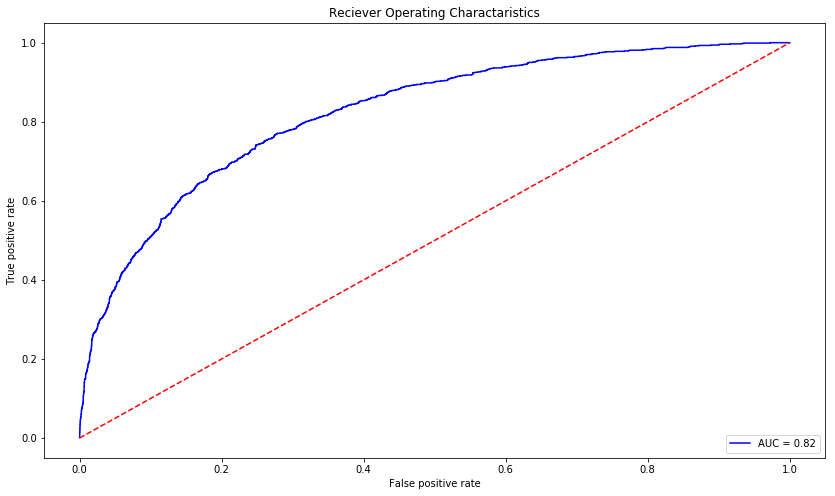

In [31]:

seed = 45
kf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
pred_test_full = 0
cv_score = []
i = 1
for train_index, test_index in kf.split(X, y):
    print('\n{} of kfold {}'.format(i, kf.n_splits))
    xtr, xvl = X.loc[train_index], X.loc[test_index]
    ytr, yvl = y[train_index], y[test_index]

    gb = GradientBoostingClassifier(learning_rate=0.1,max_depth=4,max_features=0.3,min_samples_leaf=5,n_estimators=100)
    gb.fit(xtr, ytr)
    pred_test = gb.predict_proba(xvl)[:, 1]
    score = roc_auc_score(yvl, pred_test)
    print('roc_auc_score', score)
    cv_score.append(score)
    pred_test_full += gb.predict_proba(x_test)[:, 1]
    i += 1

proba = gb.predict_proba(xvl)[:, 1]
fpr, tpr, threshold = roc_curve(yvl, proba)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(14, 8))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc_val)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [32]:
print(classification_report(y,gb.predict(X)))

             precision    recall  f1-score   support

          0       0.88      0.97      0.92     50362
          1       0.68      0.32      0.43     10030

avg / total       0.84      0.86      0.84     60392



## Averaging the toatal probability got in 10 iterations

In [46]:
y_pred=pred_test_full/10

## Since our train data had only 16% customers who had claims, we will keep the same threshold in the test data, so if probability of class 1 thats is the class for claim is more than 0.16, we will skip that and keep the rest as customers having low probability of claim

In [47]:
Low = pd.DataFrame({'QuoteNumber':clean_data_2018['quote_number'],'claim_prob':y_pred})
Low['claim_low'] = Low['claim_prob'].apply(lambda x: 1 if x>0.1666 else 0)

In [48]:
Low[Low.claim_prob>.16].head()

,QuoteNumber,claim_prob,claim_low
1,16732441,0.407652,1
2,68744228,0.833729,1
6,58572612,0.266313,1
11,35005918,0.310478,1
16,75159402,0.197873,1


In [49]:
#Number of cusotmer predicted as having low claims

Low[Low.claim_low==0].count()

QuoteNumber    5087
claim_prob     5087
claim_low      5087
dtype: int64

In [50]:
# Adding probability metric to our original dataset for future use
df_2018["claim"]=Low.claim_low
data_2018["claim"]=Low.claim_low

## Predicting Claim Severity for future with those who has probability more than 0.16 and are identified as potential customers for asking claims

In [51]:
# creating new dataframe for regression, keeping only those who had claim in 2017, 
# and those predicted for claim in 2018

claim_severity_train=data_2017[data_2017.claim>0]
claim_severity_test=data_2018[data_2018.claim>0]

# Creating metric for cost per claim

In [52]:
claim_severity_train["amountperclaim"]=(claim_severity_train.claimcst0/claim_severity_train.numclaims)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Looking at the distribution of cost per claim amount

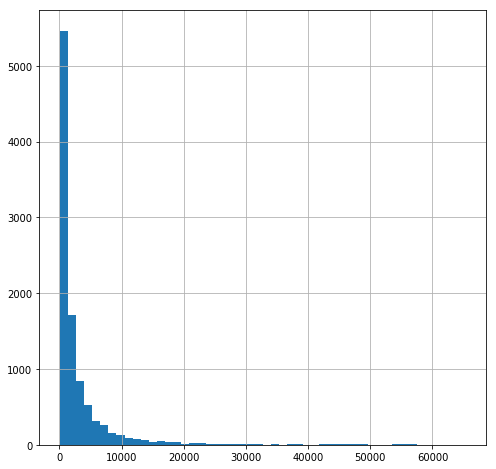

In [53]:
claim_severity_train.amountperclaim.hist(figsize=(8,8),bins=50)

## Since our data is skewed,  we will do a log transform for this metric in order to remove skewness

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


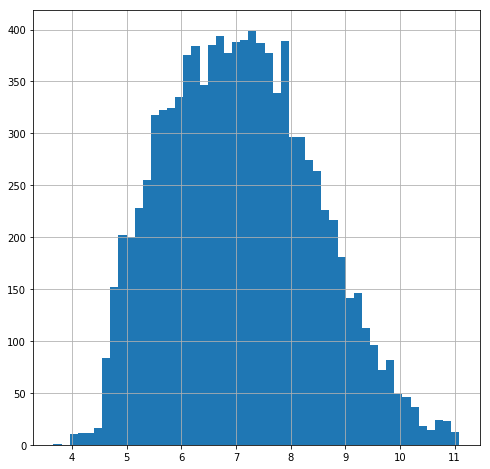

In [54]:
claim_severity_train["log_amount"]=(claim_severity_train.amountperclaim+1).apply(np.log)
claim_severity_train["log_amount"].hist(figsize=(8,8),bins=50)

In [55]:
# Creating X and Y for regression analysis

X_reg=claim_severity_train.drop(["numclaims","claimcst0","claim","amountperclaim","log_amount"],axis=1)
y_reg=claim_severity_train.log_amount

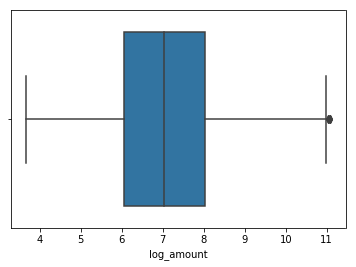

In [56]:
# Looking at our target variable just to see if there are any outliers
sns.boxplot(x=y_reg)

In [57]:
# train-test split

X_regtrain, X_regtest, y_regtrain, y_regtest = train_test_split(X_reg,y_reg,random_state = 0)

## Running Gradient Boosting with Hyperparameter Tuning

In [58]:
param_grid={'n_estimators':[200],
            'learning_rate': [0.1, 0.05, 0.02],
            'max_depth':[6],
            'min_samples_leaf':[3,5], 
            'max_features':[1.0,0.3,0.1] }

gbrt = GradientBoostingRegressor(random_state = 0)
grid_search = GridSearchCV(gbrt, param_grid, cv=5)
grid_search.fit(X_regtrain, y_regtrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'learning_rate': [0.1, 0.05, 0.02], 'max_depth': [6], 'min_samples_leaf': [3, 5], 'max_features': [1.0, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 6, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 200}


In [60]:
gbrt = GradientBoostingRegressor(learning_rate=0.05,max_depth=6,max_features=0.3,min_samples_leaf=5,n_estimators=200)
gbrt.fit(X_regtrain, y_regtrain)
predGB=gbrt.predict(X_regtest)

In [61]:
print("RSquare on test set of the model: ",r2_score(predGB,y_regtest))
print("Mean Square Error of the model: ",mean_squared_error(predGB,y_regtest))

RSquare on test set of the model:  0.7393909364001772
Mean Square Error of the model:  0.3592986721455435


## Running Random Forest with Hyperparameter tuning

In [62]:
param_grid = {"max_depth": np.arange(5,10,20),
              "max_features": [1, 5, 10,15],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10]}

rand = RandomForestRegressor(random_state = 0)
grid_search = GridSearchCV(rand, param_grid, cv=5)
grid_search.fit(X_regtrain, y_regtrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([5]), 'max_features': [1, 5, 10, 15], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 10}


In [64]:
rand = RandomForestRegressor(max_depth=5, max_features=10, min_samples_split=10, min_samples_leaf=3)
rand.fit(X_regtrain, y_regtrain)
predRF=rand.predict(X_regtest)

In [65]:
print("RSquare on test set of the model: ",r2_score(predRF,y_regtest))
print("Mean Square Error of the model: ",mean_squared_error(predRF,y_regtest))

RSquare on test set of the model:  0.31721004257289764
Mean Square Error of the model:  0.6111384676424245


## Gradient boosting gives us the best results with R2 of 0.73 and very low MSE, hence we will use Gradient boosting for final prediction

In [66]:
predGB=pd.DataFrame(predGB)
predGB=predGB.apply(np.exp)

## Predicting Claim severity for 2018 customers

In [67]:
claim_severity_test.head()

,credit_score,traffic_index,veh_age,veh_value,agecat_new,gender_M,area_B,area_C,area_D,area_E,...,veh_body_HDTOP,veh_body_MCARA,veh_body_MIBUS,veh_body_PANVN,veh_body_RDSTR,veh_body_SEDAN,veh_body_STNWG,veh_body_TRUCK,veh_body_UTE,claim
1,567.0,104.416636,3,1.124605,2,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,378.0,111.400000,3,1.210154,6,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
6,647.0,156.000000,3,1.364815,3,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
11,619.0,147.000000,3,0.682592,2,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
16,328.0,86.800000,4,0.817575,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [68]:
X_reg_test=claim_severity_test.drop(["claim"],axis=1)
predtest=gbrt.predict(X_reg_test)

## We will have to do inverse transform of our predicted values so as to get the actual values as we performed log transform to remove skewness

In [69]:
predtest=pd.DataFrame(predtest)
predtest=predtest.apply(np.exp)

# Finding lowest 10% of the prdecited claim customers

In [72]:
n=math.floor(0.1*len(pred_test))
Lowest=predtest.nsmallest(n,0)
Lowest=Lowest.rename({0:'Claim_Severity'},axis=1)

In [73]:
CustomerClaims=df_2018.join(Lowest,how='right')
CustomerClaims.head()

,quote_number,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,Claim_Severity
1123,56309410,M,NaN,8/30/1950,815.0,C,133.5,2,STNWG,3.432,132.227899
1056,41776956,F,4.0,5/11/1969,729.0,B,99.6,1,TRUCK,2.288,133.239452
1977,44245064,F,4.0,6/16/1967,657.0,C,147.0,4,HBACK,0.726,133.848812
1156,77155904,F,6.0,7/2/1934,846.0,A,116.9,4,SEDAN,0.506,135.097561
779,31595032,M,4.0,7/20/1969,810.0,A,47.3,2,HBACK,1.782,137.433688


# Generating Risk Profile based on probability of claim

In [74]:
RiskProfile=df_2018.copy()
RiskProfile["ClaimProb"]=Low.claim_prob

In [75]:
def risk(X):
    
    """ Functions generates Risk profile based on probability of claim
            and gives out 3 profiles, Low, Medium and High"""
    
    risk=[]
    if X<0.166:
        risk="Low"
    elif 0.166<=X<0.4:
        risk="Medium"
    else:
        risk="High"
    return(risk)
RiskProfile["Risk"]=RiskProfile.ClaimProb.apply(risk)

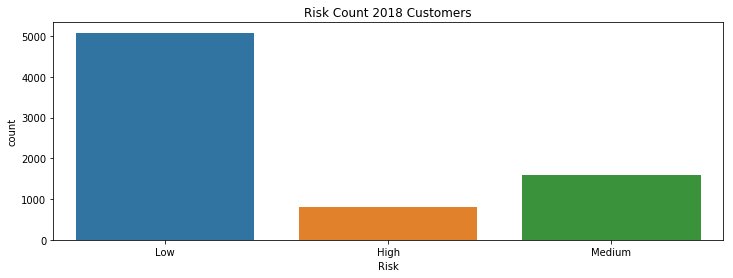

In [76]:
fig, ax1 = plt.subplots()
fig.set_size_inches(12,4)
g = sns.countplot(x='Risk',data=RiskProfile)
title = g.set_title('Risk Count 2018 Customers')

In [ ]:
RiskProfile.to_csv("finall.csv")